In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import rec_gym
from rec_gym.wrappers import StatsWrapper, FlattenObservationsWrapper
from copy import deepcopy
from rec_gym.runner import run_experiment

In [3]:
from agents.baselines import RandomAgent
from agents.dqn import Qagent
from agents.ddpg import DDPGAgent
import tensorflow as tf

# =================================

from agents.baselines import Agent
import numpy as np

class DotProdAgent(Agent):
    def __init__(self, n_rec):
        self.n_rec = n_rec
        
    def begin_episode(self, observation):
        user, items = observation
        scores = [user.dot(i) for i in items]
        idxs = np.argsort(scores)[::-1][:self.n_rec]
        return idxs
        

    def step(self, reward, observation):
        user, items = observation
        scores = [user.dot(i) for i in items]
        idxs = np.argsort(scores)[::-1][:self.n_rec]
        return idxs

    def end_episode(self, reward):
        raise NotImplemented
        
# =================================


from agents.baselines import Agent
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import dot, Concatenate, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MSE

class MFAgent(Agent):
    def __init__(self, n_rec, state_dim, action_dim, sess):
        self.n_rec = n_rec
        self.state_dim = state_dim
        self.action_dim = action_dim 
        self.sess = sess
        
        self.user_ph = Input(shape=(self.state_dim,), name='user')
        self.item_ph = Input(shape=(self.action_dim,), name='item')
        self.true_ph = Input(shape=(1,), name='true')
        
        
        net = Dense(20)(Concatenate()([self.user_ph, self.item_ph]))
        net = Dense(1)(net)
        self.rank_op = net
        
        
        self.loss = MSE(self.rank_op, self.true_ph)
        
        self.model = Model(inputs=[self.user_ph,
                                  self.item_ph],
                          outputs=self.rank_op)
        
        self.model.compile(loss=MSE, optimizer="adam")
        
        self.lr = 1e-4
        self.batch = 32
        self.n_iter = 10
        
        self.memory = []
        
        self.last_action = None
        self.last_user = None
        
    
    def _train(self):
        
        if len(self.memory) >= self.batch:
            for i in range(self.n_iter):
                
                batch_idxs = np.random.choice(range(len(self.memory)), size=self.batch)
                users, items, true_scores = zip(*[self.memory[i] for i in batch_idxs])
                
                self.model.fit([users, items, true_scores])
    
    def _get_actions(self, observation):
        user, items = observation
        
        scores = []
        for i in items:
            score = self.sess.run(self.rank_op, feed_dict = {
                self.user_ph : user[None],
                self.item_ph : i[None],
            })
            scores.append(score[0][0])
        
        idxs = np.argsort(scores)[::-1][:self.n_rec]
        
        self.last_action = [items[i] for i in idxs]
        self.last_user = user
        return idxs
        
    def begin_episode(self, observation):
        self.sess.run(tf.global_variables_initializer())
        idxs = self._get_actions(observation)
        return idxs
        

    def step(self, reward, observation):
        for i, item in enumerate(self.last_action):
            self.memory.append([self.last_user, item, reward/self.n_rec])
        self.last_action = None
        self.last_user = None
        
        idxs = self._get_actions(observation)
        return idxs

    def end_episode(self, reward):
        raise NotImplemented

# =================================

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:

def prepare_random_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    action_size = env.unwrapped.n_rec
    agent = RandomAgent(action_size = action_size)    
    return agent, wrapped, env

def prepare_ddpg_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    agent = DDPGAgent(action_size = action_size,
                     state_dim = state_dim,
                     action_dim = action_dim,
                     gamma = .9,
                     sess = sess,
                     optimizer = tf.train.AdamOptimizer(
                         learning_rate=0.01
                     ),
                     max_tf_checkpoints_to_keep = 3,
                     experience_size = 300,
                     per = True,
                     batch_size = 64, 
                     start_steps = 400)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env

def prepare_dqn_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = Qagent(sess=sess,
                     state_dim=(state_dim,),
                     action_dim=(action_dim,),
                     epsilon=0.2,
                     action_size=action_size,
                     logdir=None,
                     replay_size=1000,
                     batch_size=50)
    sess.run(tf.global_variables_initializer())
    
    return agent, wrapped, env

def prepare_dotprod_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    agent = DotProdAgent(n_rec=action_size)
    return agent, wrapped, env

def prepare_mf_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = MFAgent(n_rec=action_size, state_dim=state_dim, action_dim=action_dim, sess=sess)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env

In [13]:
from collections import defaultdict
# [EnvId][Agent] = Interactions
results = defaultdict(dict)

In [14]:
from tqdm import tqdm_notebook

In [ ]:
envids = [
    'MovieLens-v1', 
   'MovieLens-v2', 
   'MovieLens-v3', 
   'MovieLens-v4'
]
agents = {
        'random' : lambda x : prepare_random_agent_and_env(x),
        'dqn'    : lambda x : prepare_dqn_agent_and_env(x),
        'ddpg'   : lambda x : prepare_ddpg_agent_and_env(x),
        'mf_agent' : lambda x : prepare_mf_agent_and_env(x),
        'dotprod' : lambda x : prepare_dotprod_agent_and_env(x)
    }
n_steps = [5000, 5000, 12000, 12000]

for envid, n_step in tqdm_notebook(zip(envids, n_steps), leave=False, position=0):

    base_env = StatsWrapper(gym.make(envid))
    base_env.unwrapped.n_rec

    for agent_name, prepare in agents.items():
        agent, wrapped, env = prepare(base_env)
        run_experiment(wrapped, agent, t_train=n_step, t_test=0)
        
        results[envid][agent_name] = env.interactions

100%|██████████| 5000/5000 [00:01<00:00, 2520.49it/s]
0it [00:00, ?it/s]
/home/anton/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
 34%|███▍      | 1698/5000 [02:51<05:33,  9.90it/s]

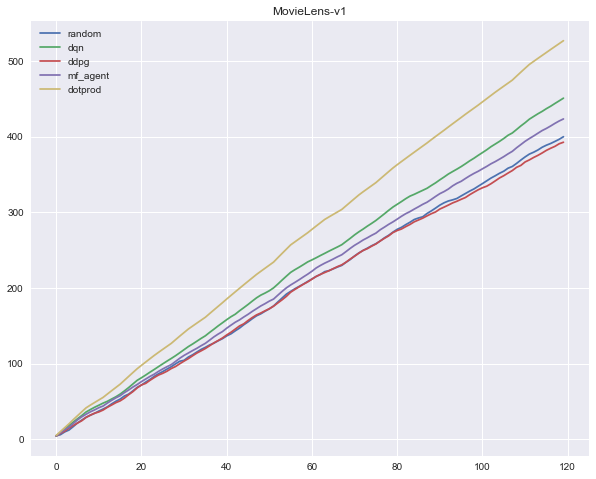

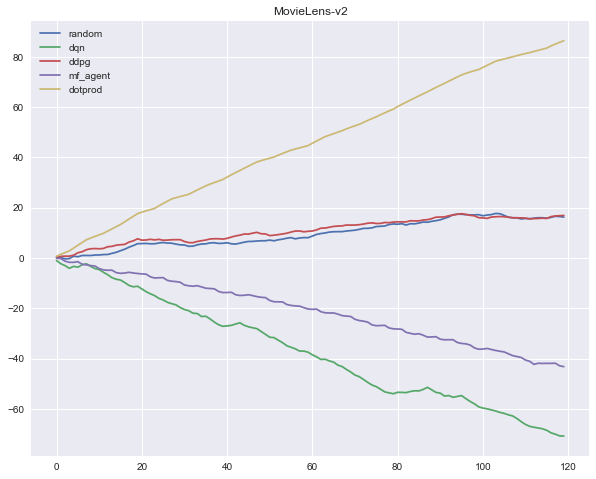

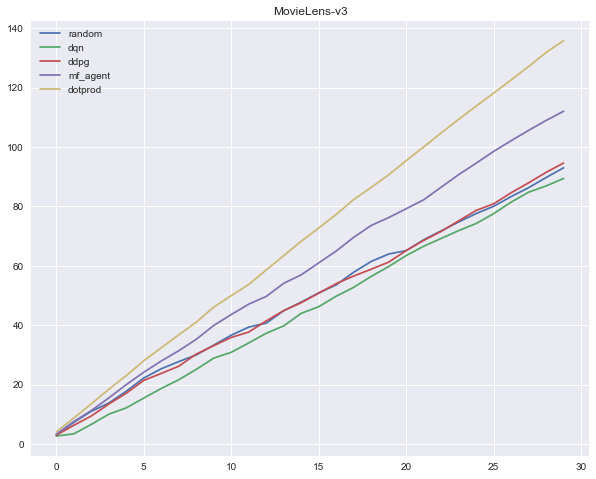

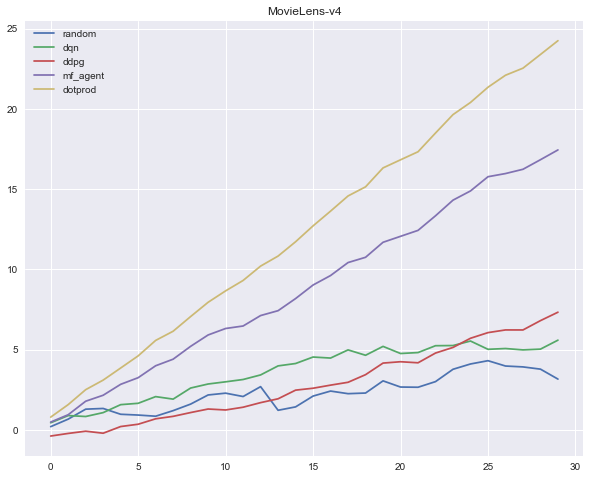

In [11]:
import matplotlib.pylab as plt
%matplotlib inline

for envid, res in results.items():
    
    plt.figure(figsize=(10, 8))
    
    for agent_name, interactions in res.items():
        rewards = []
        for i in interactions:
            rewards.extend(i.rewards)
        
        plt.plot(np.cumsum(rewards), label=agent_name)
    
    plt.legend()
    plt.title(envid)
    
#results['MovieLens-v1']['ddpg']